In [140]:
import numpy as np
import matplotlib.pyplot as plt
from cadet import Cadet
Cadet.cadet_path = '/Users/hoangnguyen/cadet-core/cadet/bin/cadet-cli'

# 1. Setting up the model

In [141]:
model = Cadet()
model.root.input.model.nunits = 3

## Inlet model

In [142]:
model.root.input.model.unit_000.unit_type = 'INLET'
model.root.input.model.unit_000.ncomp = 1
model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

## General Rate Model

In [143]:
model.root.input.model.unit_001.unit_type = 'GENERAL_RATE_MODEL'
model.root.input.model.unit_001.ncomp = 1

## Geometry
model.root.input.model.unit_001.col_length = 0.1                # m
model.root.input.model.unit_001.cross_section_area = 0.01       # m
model.root.input.model.unit_001.col_porosity = 0.37             # -
model.root.input.model.unit_001.par_porosity = 0.33             # -
model.root.input.model.unit_001.par_radius = 1e-6               # m
                                                                
## Transport
model.root.input.model.unit_001.col_dispersion = 1e-8           # m^2 / s (interstitial volume)
model.root.input.model.unit_001.film_diffusion = [1e-5]         # m / s
model.root.input.model.unit_001.par_diffusion = [1e-10,]        # m^2 / s (mobile phase)  
model.root.input.model.unit_001.par_surfdiffusion = [0.0,]      # m^2 / s (solid phase)

### Adsorption model

In [144]:
model.root.input.model.unit_001.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'
model.root.input.model.unit_001.adsorption.is_kinetic = True    # Kinetic binding
model.root.input.model.unit_001.adsorption.mcl_ka = [1.0,]      # m^3 / (mol * s)   (mobile phase)
model.root.input.model.unit_001.adsorption.mcl_kd = [1.0,]      # 1 / s (desorption)
model.root.input.model.unit_001.adsorption.mcl_qmax = [100.0,]  # mol / m^3   (solid phase)

### Initial conditions

In [145]:
model.root.input.model.unit_001.init_c = [0.0,]
model.root.input.model.unit_001.init_q = [0.0,]

### Setting up the Discretization

In [146]:
### Grid cells
model.root.input.model.unit_001.discretization.ncol = 20
model.root.input.model.unit_001.discretization.npar = 5

### Bound states
model.root.input.model.unit_001.discretization.nbound = [1]

### Other options
model.root.input.model.unit_001.discretization.par_disc_type = 'EQUIDISTANT_PAR'    
model.root.input.model.unit_001.discretization.use_analytic_jacobian = 1
model.root.input.model.unit_001.discretization.reconstruction = 'WENO'
model.root.input.model.unit_001.discretization.gs_type = 1
model.root.input.model.unit_001.discretization.max_krylov = 0
model.root.input.model.unit_001.discretization.max_restarts = 10
model.root.input.model.unit_001.discretization.schur_safety = 1.0e-8

model.root.input.model.unit_001.discretization.weno.boundary_model = 0
model.root.input.model.unit_001.discretization.weno.weno_eps = 1e-10
model.root.input.model.unit_001.discretization.weno.weno_order = 3

## Outlet model

In [147]:
model.root.input.model.unit_002.unit_type = 'OUTLET'
model.root.input.model.unit_002.ncomp = 1

# 2. Setting up time sections and connections

## Time sections

In [148]:
model.root.input.solver.sections.nsec = 1
model.root.input.solver.sections.section_times = [0.0, 1200,]   # s
model.root.input.solver.sections.section_continuity = []

In [149]:
model.root.input.model.unit_000.sec_000.const_coeff = [1.0e-3,] # mol / m^3
model.root.input.model.unit_000.sec_000.lin_coeff = [0.0,]
model.root.input.model.unit_000.sec_000.quad_coeff = [0.0,]
model.root.input.model.unit_000.sec_000.cube_coeff = [0.0,]

## System Connectivity

In [150]:
model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, 60/1e6,  # [unit_000, unit_001, all components, all components, Q/ m^3*s^-1] 
    1, 2, -1, -1, 60/1e6]  # [unit_001, unit_002, all components, all components, Q/ m^3*s^-1] 

# 3. Setting up the Simulator and running the simulation

In [151]:
model.root.input.model.solver.gs_type = 1
model.root.input.model.solver.max_krylov = 0
model.root.input.model.solver.max_restarts = 10
model.root.input.model.solver.schur_safety = 1e-8

# Number of cores for parallel simulation
model.root.input.solver.nthreads = 1

# Tolerances for the time integrator
model.root.input.solver.time_integrator.abstol = 1e-6
model.root.input.solver.time_integrator.algtol = 1e-10
model.root.input.solver.time_integrator.reltol = 1e-6
model.root.input.solver.time_integrator.init_step_size = 1e-6
model.root.input.solver.time_integrator.max_steps = 1000000

In [152]:
# Return data
model.root.input['return'].split_components_data = 0
model.root.input['return'].split_ports_data = 0
model.root.input['return'].unit_000.write_solution_bulk = 1
model.root.input['return'].unit_000.write_solution_inlet = 1
model.root.input['return'].unit_000.write_solution_outlet = 1

# Copy settings to the other unit operations
model.root.input['return'].unit_001 = model.root.input['return'].unit_000
model.root.input['return'].unit_002 = model.root.input['return'].unit_000

In [153]:
# Solution times
model.root.input.solver.user_solution_times = np.linspace(0, 1200, 1001)


In [154]:
model.filename = 'cadet-introduction.h5'
model.save()

data = model.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    model.load()
else:
    print(data)
    raise Exception("Simulation failed")

Simulation completed successfully


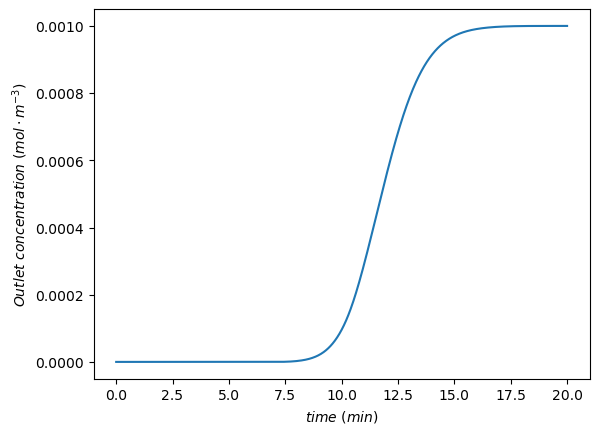

In [158]:
# 4. Plotting the results
plt.figure()
time = model.root.output.solution.solution_times
c = model.root.output.solution.unit_001.solution_outlet
plt.plot(time/60, c)
plt.xlabel('$time~(min)$')
plt.ylabel('$Outlet~concentration~(mol \cdot m^{-3})$')
plt.show()